Створимо набір даних з нашого csv файлу

In [79]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

def getDataset():
    data = pd.read_csv('Export1.csv',sep=';',encoding='cp1252')
    return data

dataset = getDataset()

Перевіримо їх на нормальність

In [80]:
dataset = dataset.drop(dataset.columns[[0, 1, 2, 3, 4, 6]], axis=1)

import scipy.stats as stats
def kolm_smirn_check(dFrame, column):
    ks_statistic, p_value = stats.kstest(dFrame[column], 'norm')
    if p_value > 0.05: return True
    return False

def pearson_check(dFrame, column):
    statistic, p_value = stats.normaltest(dFrame[column])
    if p_value > 0.05: return True
    return False

print("#1 test - Kolmagorov-Smirnov test,\n#2 test - Pearson test\n")
for c in dataset.columns:
    print('{0:<15}'.format(c + ":"),f"#1 test - {kolm_smirn_check(dataset, c)}, #2 test - {pearson_check(dataset, c)};")


#1 test - Kolmagorov-Smirnov test,
#2 test - Pearson test

ratio:          #1 test - False, #2 test - False;
gdp:            #1 test - False, #2 test - False;
population:     #1 test - False, #2 test - False;
sales_of_cigarettes_per_adult_per_day: #1 test - False, #2 test - False;
annual_co2_emissions_tonnes: #1 test - False, #2 test - False;


Перевіримо коефіцієнти корреляції

In [81]:
dataset.corr()

,ratio,gdp,population,sales_of_cigarettes_per_adult_per_day,annual_co2_emissions_tonnes
ratio,1.000000,0.774552,0.137843,-0.047489,0.090640
gdp,0.774552,1.000000,0.243990,-0.167556,0.247694
population,0.137843,0.243990,1.000000,0.045570,0.955826
sales_of_cigarettes_per_adult_per_day,-0.047489,-0.167556,0.045570,1.000000,0.003515
annual_co2_emissions_tonnes,0.090640,0.247694,0.955826,0.003515,1.000000


Розіб'ємо дані на тренувальні та тестові параметри та залежну змінну

In [82]:
from sklearn.model_selection import train_test_split

data = dataset.iloc[:,1:5]
fact = dataset['ratio']
X_train, X_test, Y_train, Y_test = train_test_split(data, fact,test_size = 0.25,random_state = 0)

Лінійна регресія.
Підготуємо всі можливі набори параметрів для моделювання та власне застосуємо лінійну регресію до кожного з них

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

X_variant_tuples = ["gdp", "population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes",
    
                    ["gdp", "population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"],
                    ["gdp", "population"], ["gdp", "sales_of_cigarettes_per_adult_per_day"], ["gdp", "annual_co2_emissions_tonnes"],
                    ["population", "sales_of_cigarettes_per_adult_per_day"], ["population", "annual_co2_emissions_tonnes"],
                    ["sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"],

                    ["gdp", "population", "sales_of_cigarettes_per_adult_per_day"], 
                    ["gdp", "population","annual_co2_emissions_tonnes"], 
                    ["gdp", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"], 
                    ["population", "sales_of_cigarettes_per_adult_per_day", "annual_co2_emissions_tonnes"]]

linear_regression_models_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
        linear_regression_models_list.append(LinearRegression().fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        linear_regression_models_list.append(LinearRegression().fit(X_train[X_variant_tuples[i]], Y_train))
        

Тепер для кожної нашої моделі спроєктуємо передбачення та будемо зберігати його в массиві даних

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
MSE = []
R2 = []

prediction = []

def predict_by(prediction, s):
    for i in range(len(X_variant_tuples)):
        if i < 4:
            prediction.append(s[i].predict(X_test[X_variant_tuples[i]].to_numpy().reshape(-1,1)))
        else:
            prediction.append(s[i].predict(X_test[X_variant_tuples[i]]))

    return prediction

prediction = predict_by(prediction, linear_regression_models_list)
#print(prediction)

Для кожного з передбачень обрахуємо MSE та R2.
Для MSE побудужмо графік для наочності та аби зрозуміти, яка сама модель є ефективнішою

MSE plot


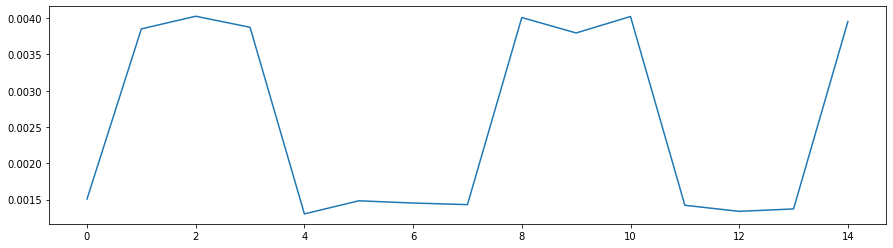

0.6289405784063854


In [85]:
for i in range(len(prediction)):
    MSE.append(mean_squared_error(Y_test,prediction[i]))
    R2.append(r2_score(Y_test,prediction[i]))

import matplotlib.pyplot as plt
#print(MSE)
print("MSE plot")
plt.plot(MSE)
plt.show()

#print("R2 Plot")
#plt.plot(R2)
#plt.show()
print(linear_regression_models_list[4].score(X_train, Y_train))

Програмно порахуємо та визначимо, яка модель є найкращою

In [86]:
def get_minvalue(inputlist):
    #get the minimum value in the list
    min_value = min(inputlist)
    #return the index of minimum value 
    min_index=inputlist.index(min_value)
    return min_index

print("Best model is:")
print(f"linear model by {X_variant_tuples[get_minvalue(MSE)]} params")
print("Just score: ", linear_regression_models_list[get_minvalue(MSE)].score(X_train, Y_train))
print("Particulary R2_score: ", r2_score(Y_test,prediction[get_minvalue(MSE)]))

Best model is:
linear model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params
Just score:  0.6289405784063854
Particulary R2_score:  0.6572330194601623


In [87]:
from sklearn.linear_model import LogisticRegression

Тепер, знаючи, яка модель є найкращою, за допомогою кастомної функції, продемонструємо графік Learning Curve

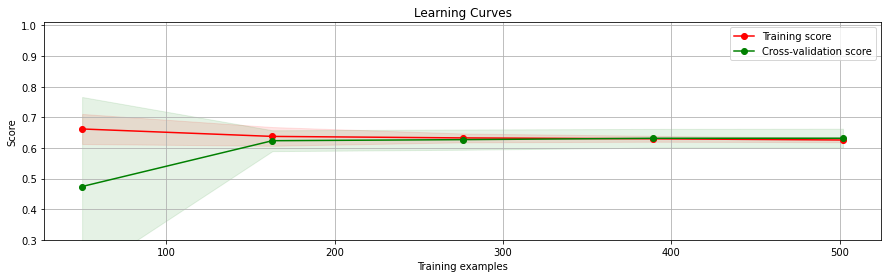

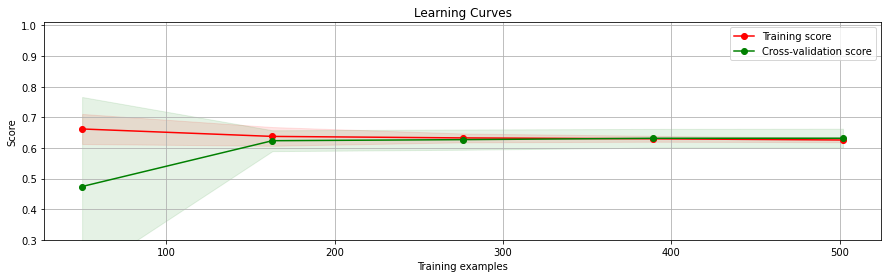

In [88]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(linear_regression_models_list[4], "Learning Curves", X_train, Y_train, (0.3, 1.01), cv=cv, n_jobs=4)
plt.show()
plot_learning_curve(linear_regression_models_list[12], "Learning Curves", X_train, Y_train, (0.3, 1.01), cv=cv, n_jobs=4)
plt.show()

Графік точності передбачення

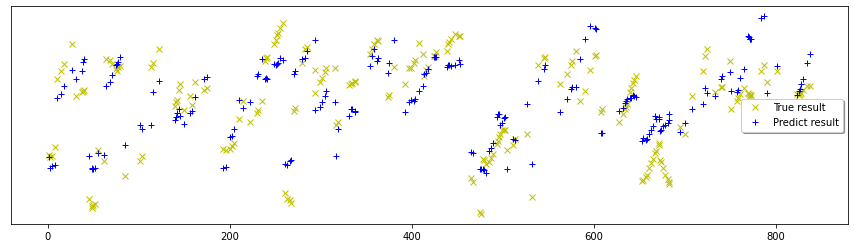

In [89]:
def show_accuracy_plot(estimator):
    plt.rcParams["figure.figsize"] = (15,4)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.plot(X_test.index, Y_test, "yx", label = "True result")
    plt.plot(X_test.index, estimator.predict(X_test), "b+", label = "Predict result")
    plt.legend(loc="center right", shadow=True)
    plt.show()
    
show_accuracy_plot(linear_regression_models_list[4])

Random Forest Regression.
Для кожного кортежу застосуємо дану модель

In [90]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regression_model_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
        random_forest_regression_model_list.append(RandomForestRegressor(n_estimators=300, max_features=5).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        random_forest_regression_model_list.append(RandomForestRegressor(n_estimators=300, max_features=5).fit(X_train[X_variant_tuples[i]], Y_train))

In [91]:
random_forest_prediction = []
random_forest_prediction = predict_by(random_forest_prediction, random_forest_regression_model_list)
#print(random_forest_prediction)

[0.0013069601989216834, 0.0033497106963858653, 0.004741327175561535, 0.0032362627496175544, 0.0002640297971188966, 0.0004163602526465438, 0.0007827820189329631, 0.0005165341090174537, 0.0016354556047976018, 0.0009627780391695678, 0.002058958208539401, 0.00028760452555292324, 0.00031574635975824115, 0.0003976929893578606, 0.0007129426034164927]


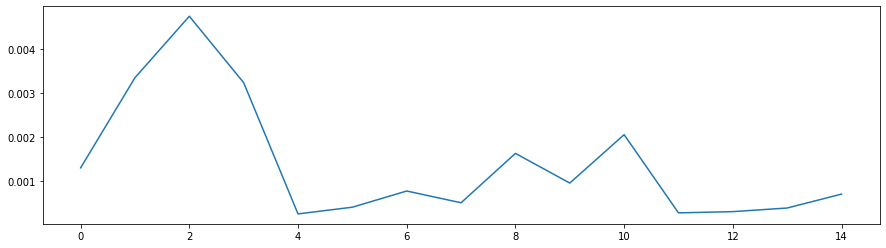

0.9923455071013207


In [92]:
MSE_forest = []
R2_forest = []
for i in range(len(random_forest_prediction)):
    MSE_forest.append(mean_squared_error(Y_test,random_forest_prediction[i]))
    R2_forest.append(r2_score(Y_test,random_forest_prediction[i]))

print(MSE_forest)
#plt.plot(R2)
plt.plot(MSE_forest)
plt.show()
print(random_forest_regression_model_list[4].score(X_train, Y_train))

In [93]:
print("Best model is:")
print(f"Random Forest Regressor model by {X_variant_tuples[get_minvalue(MSE_forest)]} params")
print("Just score: ", random_forest_regression_model_list[get_minvalue(MSE_forest)].score(X_train, Y_train))
print("Particulary R2_score: ", r2_score(Y_test,random_forest_prediction[get_minvalue(MSE_forest)]))

Best model is:
Random Forest Regressor model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params
Just score:  0.9923455071013207
Particulary R2_score:  0.9305231845072461


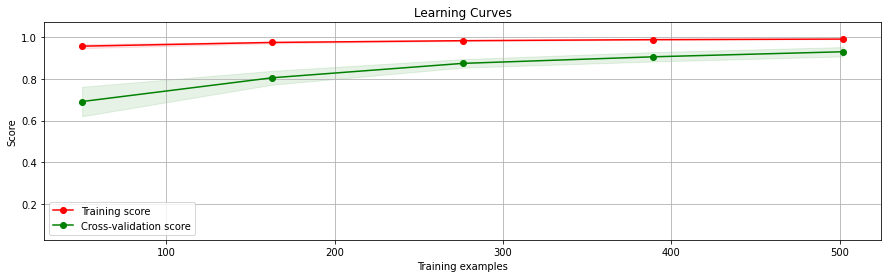

In [94]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(random_forest_regression_model_list[4], "Learning Curves", X_train, Y_train, (0.03, 1.07), cv=cv, n_jobs=4)
plt.show()

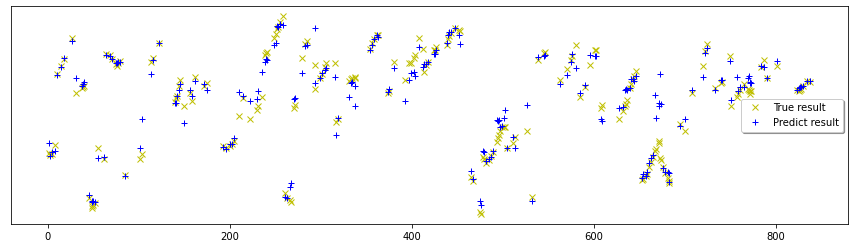

In [95]:
show_accuracy_plot(random_forest_regression_model_list[4])

Gradient Boosting Regression

In [96]:
from sklearn.ensemble import GradientBoostingRegressor

GradientBoostingRegressor_regression_model_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
       GradientBoostingRegressor_regression_model_list.append(GradientBoostingRegressor(random_state=0).fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        GradientBoostingRegressor_regression_model_list.append(GradientBoostingRegressor(random_state=0).fit(X_train[X_variant_tuples[i]], Y_train))

In [97]:
GradientBoostingRegressor_prediction = []
GradientBoostingRegressor_prediction = predict_by(GradientBoostingRegressor_prediction, GradientBoostingRegressor_regression_model_list)
#print(GradientBoostingRegressor_prediction)

[0.0010190075592278716, 0.002415266531031726, 0.004567625541823404, 0.002307339469792709, 0.0003774600425782712, 0.00048558652914810856, 0.0007790543846132895, 0.0005642446384590425, 0.002110373545442584, 0.0009838206008292035, 0.0020255957954175615, 0.00041244237559842157, 0.0003880526301308858, 0.0004729935962665314, 0.0009929554451943393]


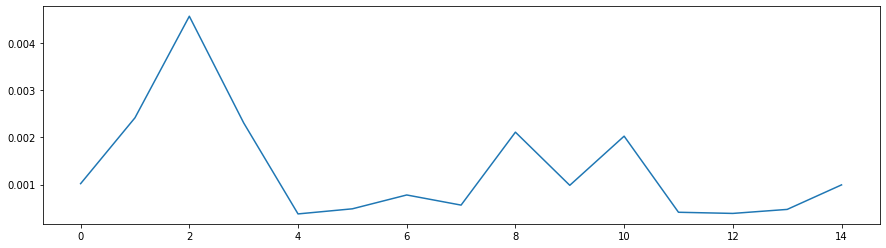

In [98]:
MSE_GradientBoostingRegressor = []
R2_GradientBoostingRegressor = []
for i in range(len(GradientBoostingRegressor_prediction)):
    MSE_GradientBoostingRegressor.append(mean_squared_error(Y_test,GradientBoostingRegressor_prediction[i]))
    R2_GradientBoostingRegressor.append(r2_score(Y_test,GradientBoostingRegressor_prediction[i]))

print(MSE_GradientBoostingRegressor)
#plt.plot(R2)
plt.plot(MSE_GradientBoostingRegressor)
plt.show()

Програмно порахуємо та визначимо, яка модель є найкращою

In [99]:
print("Best model is:")
print(f"Gradient boosting Regressor model by {X_variant_tuples[get_minvalue(MSE_GradientBoostingRegressor)]} params")
print("Just score: ", GradientBoostingRegressor_regression_model_list[get_minvalue(MSE_GradientBoostingRegressor)].score(X_train, Y_train))
print("Particulary R2_score: ", r2_score(Y_test,GradientBoostingRegressor_prediction[get_minvalue(MSE_GradientBoostingRegressor)]))

Best model is:
Gradient boosting Regressor model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params
Just score:  0.9575933994156017
Particulary R2_score:  0.900675143410847


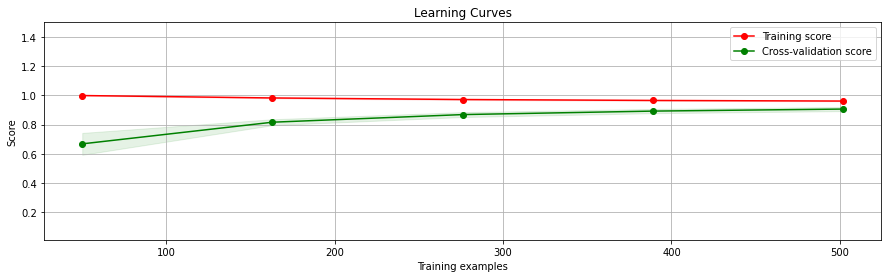

In [100]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(GradientBoostingRegressor_regression_model_list[4], "Learning Curves", X_train, Y_train, (0.01, 1.5), cv=cv, n_jobs=4)
plt.show()

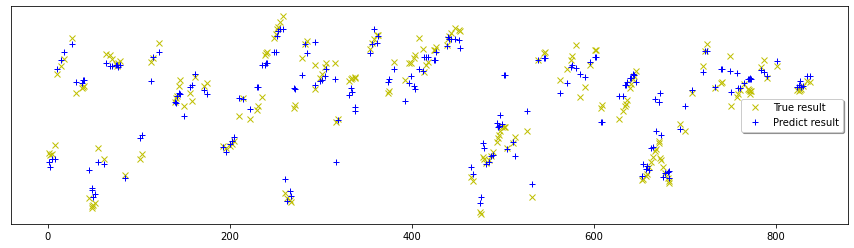

In [101]:
show_accuracy_plot(GradientBoostingRegressor_regression_model_list[4])

BayesianRidge regression

In [103]:
#from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge
BayesianRidge_model_list = []

for i in range(len(X_variant_tuples)):
    if i < 4: 
       BayesianRidge_model_list.append(BayesianRidge().fit(X_train[X_variant_tuples[i]].to_numpy().reshape(-1,1), Y_train))
    else:
        BayesianRidge_model_list.append(BayesianRidge().fit(X_train[X_variant_tuples[i]], Y_train))

In [104]:
BayesianRidge_prediction = []
BayesianRidge_prediction = predict_by(BayesianRidge_prediction, BayesianRidge_model_list)
#print(GradientBoostingRegressor_prediction)

[0.0015067597292829857, 0.003852151494575098, 0.004005281463490451, 0.003874289757312367, 0.0013173838753419936, 0.0014833530616187634, 0.001462098072989934, 0.0014306078244239366, 0.003967159517950677, 0.0037959019897356346, 0.00397963851163071, 0.001436862374442629, 0.0013379169326474655, 0.0013844189128244641, 0.0039026739240279737]


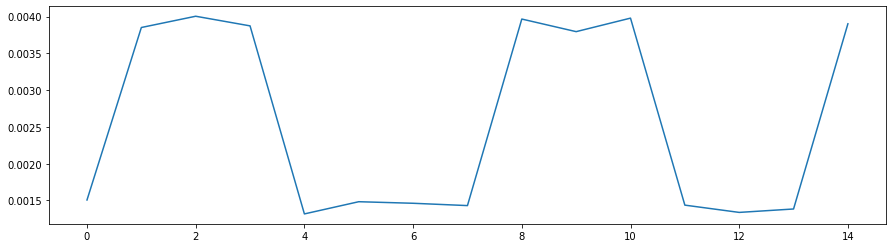

In [105]:
MSE_SGDRegressor = []
R2_SGDRegressor = []
for i in range(len(BayesianRidge_prediction)):
    MSE_SGDRegressor.append(mean_squared_error(Y_test,BayesianRidge_prediction[i]))
    R2_SGDRegressor.append(r2_score(Y_test,BayesianRidge_prediction[i]))

print(MSE_SGDRegressor)
#plt.plot(R2)
plt.plot(MSE_SGDRegressor)
plt.show()

Програмно порахуємо та визначимо, яка модель є найкращою

In [106]:
print("Best model is:")
print(f"Gradient boosting Regressor model by {X_variant_tuples[get_minvalue(MSE_SGDRegressor)]} params")
print("Just score: ", BayesianRidge_model_list[get_minvalue(MSE_SGDRegressor)].score(X_train, Y_train))
print("Particulary R2_score: ", r2_score(Y_test,BayesianRidge_prediction[get_minvalue(MSE_SGDRegressor)]))

Best model is:
Gradient boosting Regressor model by ['gdp', 'population', 'sales_of_cigarettes_per_adult_per_day', 'annual_co2_emissions_tonnes'] params
Just score:  0.6283439554083059
Particulary R2_score:  0.6533435338017987


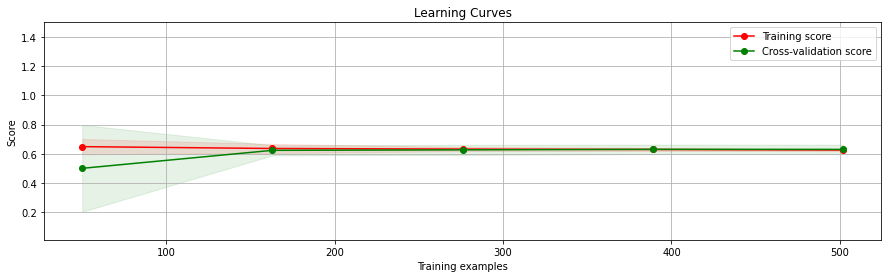

In [107]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(BayesianRidge_model_list[4], "Learning Curves", X_train, Y_train, (0.01, 1.5), cv=cv, n_jobs=4)
plt.show()

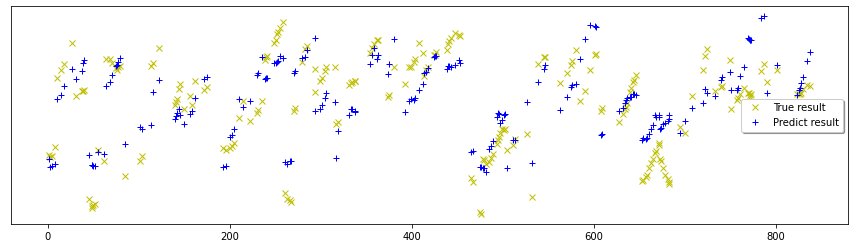

In [108]:
show_accuracy_plot(BayesianRidge_model_list[4])
